In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

# 讀入股價資料，CP/RI權重資料，並新增欄位以供寫入資料用

In [2]:
df = pd.read_csv('/Users/Kang/Desktop/1_1 Rebalance_NAV.csv', index_col = 'Date')
df_w_CP = pd.read_csv('/Users/Kang/Desktop/4_1_2 BL CP weight_adj.csv', index_col = 0)
df_w_RI = pd.read_csv('/Users/Kang/Desktop/4_2_2 BL RI weight_adj.csv', index_col = 0)
df = df.set_index(pd.to_datetime(df.index))
df_w_CP = df_w_CP.set_index(pd.to_datetime(df_w_CP.index))
df_w_RI = df_w_RI.set_index(pd.to_datetime(df_w_RI.index))

df['NAV_CP'] = np.nan
df['NAV_RI'] = np.nan

# 新增df_CP_unites跟df_RI_units用來儲存之後每個月ETF購買單位數

In [3]:
all_ticker = df_w_CP.columns
all_rebalance_day = df_w_CP.index
df_CP_units = pd.DataFrame(index = all_rebalance_day, columns = all_ticker)
df_RI_units = pd.DataFrame(index = all_rebalance_day, columns = all_ticker)
df_CP_units = df_CP_units.set_index(pd.to_datetime(df_CP_units.index))
df_RI_units = df_RI_units.set_index(pd.to_datetime(df_RI_units.index))

# 計算NAV_CP, NAV_RI

In [4]:
#用以計算到Rebalance當天的NAV
def caculate_nav(i, tem_count): #計算到第幾個rebalance day
    while tem_count < len(df): #當tem_count等於len(df)時不能跑，而且事實上也已經跑完了
        #對於比第i個權重日期還要早或相同的所有日期
        if all_rebalance_day[i] >= df.index[tem_count]:
            t = all_rebalance_day[i - 1] #是使用上一個rebalance日的權重
            df['NAV_CP'].iloc[tem_count] = sum(df[j].iloc[tem_count] * df_CP_units[j].loc[t] for j in all_ticker) #計算每天的NAV
            df['NAV_RI'].iloc[tem_count] = sum(df[j].iloc[tem_count] * df_RI_units[j].loc[t] for j in all_ticker)
            tem_count += 1
        else:
            break  
    return tem_count

def rebalance_weight(j): #計算到第幾個rebalance day
    t = all_rebalance_day[j]
    for etf in all_ticker:
        df_CP_units[etf][t] = price_to_balance_CP * df_w_CP[etf][t] / df[etf][t] #計算出Rebalance日所有etf的新權重（購買單位）
        df_RI_units[etf][t] = price_to_balance_RI * df_w_RI[etf][t] / df[etf][t] 

In [5]:
price_to_balance_CP = df['NAV'].iloc[0] #begining invest 10000
price_to_balance_RI = df['NAV'].iloc[0] #因為一次要做兩個column的NAV，要有兩個起始投資額，之後分開更新
tem_count = 0

#一開始先將第一個月全部填為10000，因為沒有2009-12的權重可用
rebalance_weight(0)
df['NAV_CP'].loc[:df_w_CP.index[0]] = price_to_balance_CP
df['NAV_RI'].loc[:df_w_RI.index[0]] = price_to_balance_RI
tem_count += len(df.loc[:df_w_CP.index[0]]) #直接越過一月所有日期

#之後在每一個rebalance日之前，都先算出所有NAV，然後用rebalance當天的etf價格，重新分配權重
for day in range(1, len(all_rebalance_day)): #第幾個rebalance day，第0個已經在上面先跑過了，從二月底2010-02-26開始做
    tem_count = caculate_nav(day, tem_count) #將自己循環代入函式，可不斷得到新的斷位點，也就是下次rebalance的當天
    price_to_balance_CP = df['NAV_CP'][tem_count - 1] #因為tem_count加一，需減一才是Rebalance當天的NAV
    price_to_balance_RI = df['NAV_RI'][tem_count - 1]
    rebalance_weight(day)

In [6]:
#從二月底開始的每個月最後一天，套用上個月的權重跟本月權重會有相同的NAV，rebalance的必然
print(sum(df[j].loc['2010-02-26'] * df_RI_units[j].loc['2010-01-29 '] for j in all_ticker))
print(sum(df[j].loc['2010-02-26'] * df_RI_units[j].loc['2010-02-26'] for j in all_ticker))

10298.058067779042
10298.058067779037


In [7]:
#df.loc[(df.index.year == 2010) & (df.index.month == 1)]

In [8]:
df_w_CP

,AGG,EMB,EWT,IVV,JNK,PFF,TLT,VGK,VNQ,VPL,VWO
2010-01-29,0.100000,0.050000,1.475006,1.231254,-0.637503,-0.981254,0.050000,-0.243751,0.443751,-1.275006,0.787503
2010-02-26,1.280256,0.050000,1.673674,0.986837,0.443419,-1.523674,0.050000,-1.080256,-0.686837,-0.293419,0.100000
2010-03-31,0.100000,0.050000,1.742806,-0.347602,-2.140408,-1.045204,1.145204,-1.542806,2.290408,0.100000,0.647602
2010-04-30,-0.405140,0.050000,0.605140,2.220559,-1.970559,0.050000,1.565419,-0.910279,-1.415419,0.100000,1.110279
2010-05-28,0.738970,0.050000,2.655881,1.477940,-2.505881,-1.866911,0.050000,2.016911,-1.177940,0.100000,-0.538970
2010-06-30,0.759809,0.050000,-1.219617,2.839235,-2.589235,-1.929426,0.050000,2.079426,-0.559809,0.100000,1.419617
2010-07-30,-0.638968,0.050000,1.577936,0.200000,-1.427936,0.788968,1.158452,-0.269484,-1.008452,0.100000,0.469484
2010-08-31,-0.946973,0.050000,0.797982,1.246973,-0.647982,-1.345964,0.398991,0.100000,-0.248991,0.100000,1.495964
2010-09-30,-0.108752,0.050000,0.517503,0.408752,-0.367503,0.050000,-0.263128,-0.004376,0.204376,0.100000,0.413128
2010-10-29,0.823948,0.050000,0.341316,0.682632,-0.915264,-0.191316,1.015264,-0.623948,0.100000,0.100000,-0.382632


In [9]:
df_w_RI

,AGG,EMB,EWT,IVV,JNK,PFF,TLT,VGK,VNQ,VPL,VWO
2010-01-29,-0.053838,0.050000,0.151279,0.200000,-0.052559,0.050000,-0.155118,0.048721,0.253838,0.305118,0.202559
2010-02-26,0.100000,0.050000,1.301201,-0.200400,0.850801,0.050000,-1.151201,-1.501601,0.500400,1.701601,-0.700801
2010-03-31,-0.018396,0.050000,0.218396,0.377594,0.050000,-0.009198,-0.186792,-0.077594,0.336792,0.100000,0.159198
2010-04-30,-0.193336,0.050000,0.100000,0.640004,0.343336,0.196668,-0.536672,-0.046668,-0.340004,0.100000,0.686672
2010-05-28,0.100000,0.050000,1.029415,0.664707,1.908829,-1.344122,-0.414707,-1.758829,-0.829415,0.100000,1.494122
2010-06-30,0.849528,0.050000,0.662146,0.387382,-0.324764,0.050000,0.424764,-0.649528,-0.462146,0.100000,-0.087382
2010-07-30,1.384194,0.050000,0.956129,0.628065,0.050000,-0.378065,-0.806129,-1.612258,-1.184194,0.100000,1.812258
2010-08-31,1.965244,0.050000,-0.521748,0.821748,1.293496,0.050000,-2.436992,-1.765244,-1.143496,0.100000,2.586992
2010-09-30,-0.081218,0.050000,0.190609,0.200000,0.231218,0.412436,-0.312436,-0.171827,0.009391,0.100000,0.371827
2010-10-29,-0.057340,0.050000,0.152447,0.357340,-0.002447,0.050000,-0.159787,-0.004893,0.204893,0.100000,0.309787


In [10]:
#df.to_csv('/Users/Kang/Desktop/5_1 NAV.csv')
#df_CP_units.to_csv('/Users/Kang/Desktop/5_2 CP weight.csv')
#df_RI_units.to_csv('/Users/Kang/Desktop/5_3 RI weight.csv')

# 畫圖

Text(0.5, 1.0, 'NAV of portfolio rebalance each month')

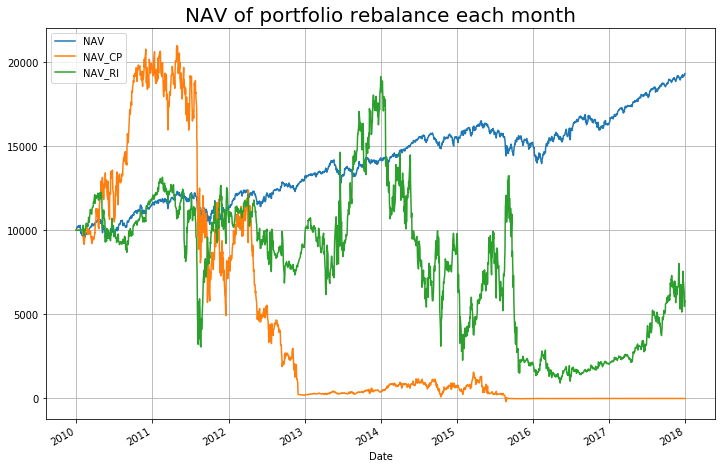

In [11]:
#figsize(12,8)
df.plot(y=['NAV', 'NAV_CP', 'NAV_RI'], figsize=(12,8), grid = True)
plt.title('NAV of portfolio rebalance each month', size = 20)

Text(0.5, 1.0, 'ETF buy units adjust with CP spread view')

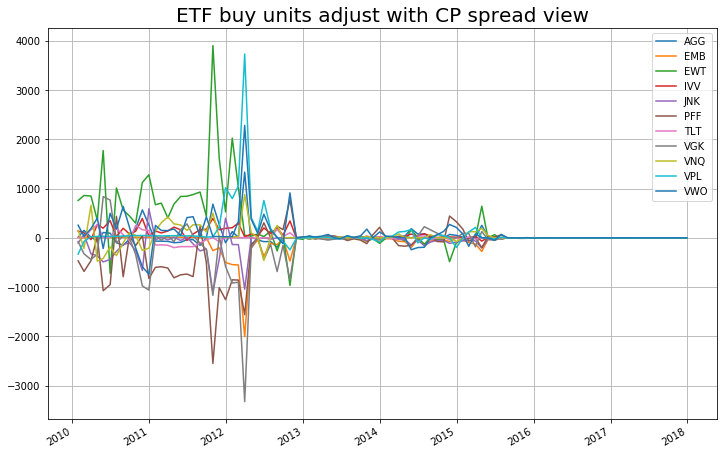

In [12]:
df_CP_units.plot(figsize=(12,8), grid=True)
plt.title('ETF buy units adjust with CP spread view', size = 20)

Text(0.5, 1.0, 'ETF buy units adjust with RI spread view')

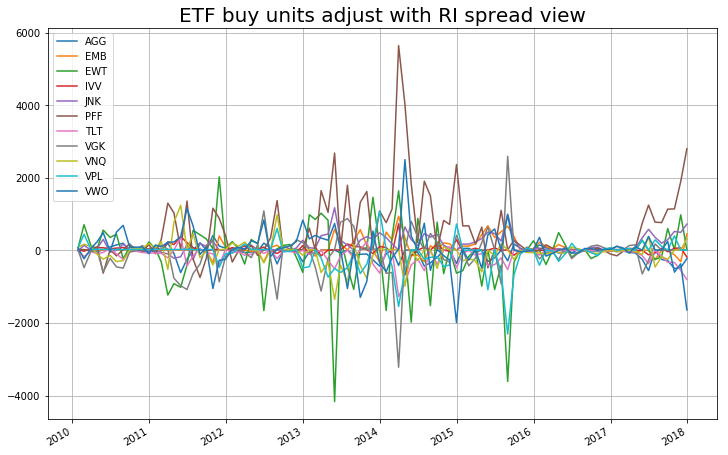

In [13]:
df_RI_units.plot(figsize=(12,8), grid=True)
plt.title('ETF buy units adjust with RI spread view', size = 20)